# Dataset statistics

In [40]:
import torch
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colormaps
from datasets import load_from_disk, Split
from transformers import AutoTokenizer

data_dir = os.path.expanduser("~/data")
output_dir = "outputs"

sns.set_style(style="white")

In [16]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## TREC

In [39]:
trec_6 = load_from_disk(os.path.join(data_dir, "trec-6"))
trec_6.set_format("torch")

trec_50 = load_from_disk(os.path.join(data_dir, "trec-50"))
trec_50.set_format("torch")

trec_50_names = trec_50[Split.TRAIN].features["label"].names

print("TREC-50")
print("Train", len(trec_50[Split.TRAIN]))
print("Validation", len(trec_50[Split.VALIDATION]))
print("Test", len(trec_50[Split.TEST]))

TREC-50
Train 4906
Validation 546
Test 500


In [81]:
classes, counts = trec_50[Split.TRAIN]["label"].unique(return_counts=True)

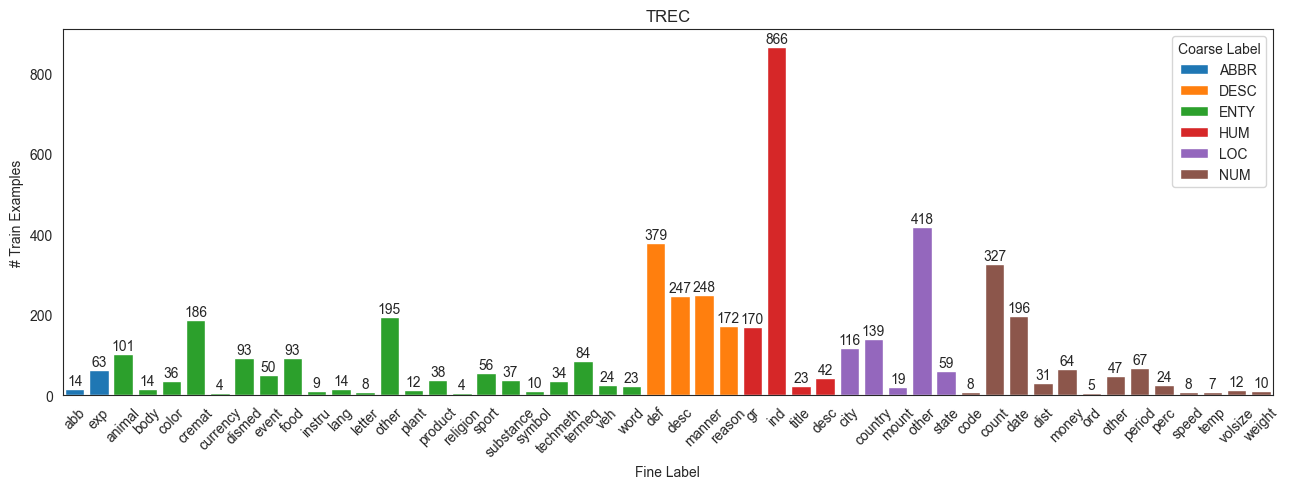

In [90]:
super_labels = np.array([name.split(":")[0] for name in trec_50_names])
tab10 = colormaps["tab10"]
cmap = {label: tab10(i) for i, label in enumerate(np.unique(super_labels))}

plt.figure(figsize=(13, 5), tight_layout=True)
ax = sns.barplot(x=classes.tolist(), y=counts.tolist())

# coloring by coarse label & display values
for idx, p in enumerate(ax.patches):
    super_label = super_labels[idx]
    p.set_facecolor(cmap[super_label])

    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 10, f'{height:.0f}', ha="center")

# rotate labels
ax.set_xticklabels([name.split(":")[1] for name in trec_50_names], rotation=45)

# legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=cmap[label]) for label in np.unique(super_labels)]
plt.legend(legend_elements, cmap.keys(), title='Coarse Label', loc='upper right')

plt.title("TREC")
plt.xlabel("Fine Label")
plt.ylabel("# Train Examples")

plt.savefig(os.path.join("outputs", "TREC.pdf"))

In [47]:
# tokenize dataset
trec_50[Split.TRAIN] = trec_50[Split.TRAIN].map(tokenizer, input_columns="text", batched=True, num_proc=8)

Map (num_proc=8):   0%|          | 0/4906 [00:00<?, ? examples/s]

In [120]:
# compute sequence lengths
lengths = trec_50[Split.TRAIN].map(lambda ids: {"length": len(ids)}, input_columns="input_ids")["length"]

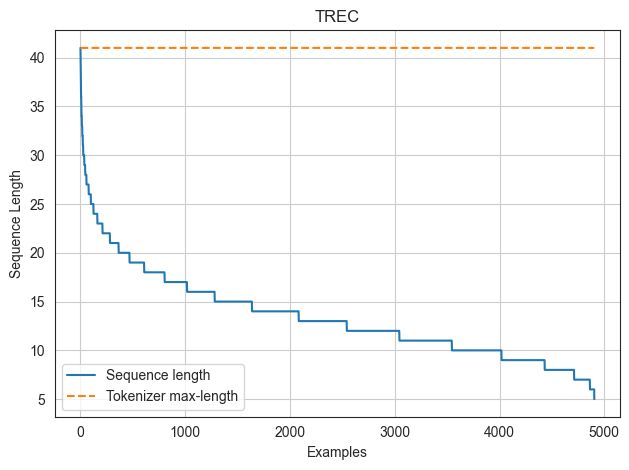

In [123]:
plt.figure(tight_layout=True)
plt.plot(lengths.sort(descending=True).values, label="Sequence length")
plt.plot(torch.ones_like(lengths) * 41, linestyle="--", label="Tokenizer max-length")

plt.title("TREC")
plt.xlabel("Examples")
plt.ylabel("Sequence Length")
plt.grid()

plt.legend()
plt.savefig(os.path.join(output_dir, "TREC-lengths.pdf"))

## IMDB

In [66]:
imdb = load_from_disk(os.path.join(data_dir, "imdb"))
imdb.set_format("torch")

imdb_names = imdb[Split.TRAIN].features["label"].names

print("IMDB")
print("Train", len(imdb[Split.TRAIN]))
print("Validation", len(imdb[Split.VALIDATION]))
print("Test", len(imdb[Split.TEST]))

IMDB
Train 22500
Validation 2500
Test 25000


In [91]:
classes, counts = imdb[Split.TRAIN]["label"].unique(return_counts=True)

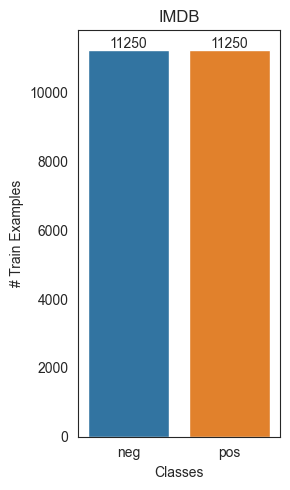

In [96]:
plt.figure(figsize=(3, 5), tight_layout=True)
ax = sns.barplot(x=imdb_names, y=counts.tolist())

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 50, f'{height:.0f}', ha="center")

plt.title("IMDB")
plt.xlabel("Classes")
plt.ylabel("# Train Examples")

plt.savefig(os.path.join("outputs", "IMDB.pdf"))

In [ ]:
# tokenize dataset
imdb[Split.TRAIN] = imdb[Split.TRAIN].map(tokenizer, input_columns="text", batched=True, num_proc=8)

In [102]:
# compute sequence lengths
lengths = imdb[Split.TRAIN].map(lambda ids: {"length": len(ids)}, input_columns="input_ids")["length"]

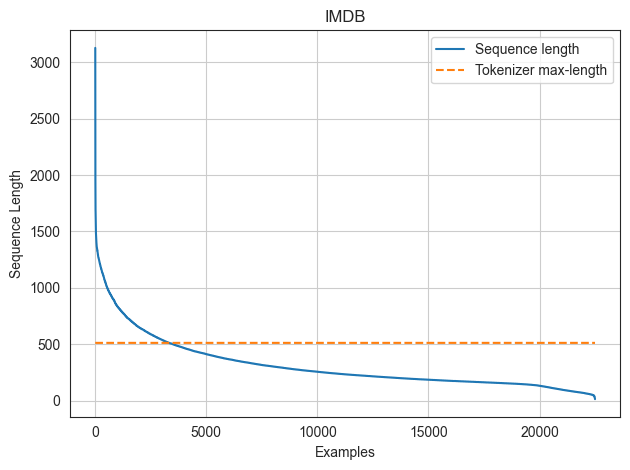

In [108]:
plt.figure(tight_layout=True)
plt.plot(lengths.sort(descending=True).values, label="Sequence length")
plt.plot(torch.ones_like(lengths) * 512, linestyle="--", label="Tokenizer max-length")

# plt.yscale("log")
# ax = plt.gca()
# formatter = ticker.StrMethodFormatter('{x:.0f}')
# ax.yaxis.set_major_formatter(formatter)

plt.title("IMDB");
plt.xlabel("Examples")
plt.ylabel("Sequence Length")
plt.grid()

plt.legend()
plt.savefig(os.path.join(output_dir, "IMDB-lengths.pdf"))

## Reuters

In [6]:
reuters_mlc = load_from_disk(os.path.join(data_dir, "ReutersMLC"))
reuters_mlc.set_format("torch")

print("Reuters (Multi-Label Classification)")
print("Train", len(reuters_mlc[Split.TRAIN]))
print("Validation", len(reuters_mlc[Split.VALIDATION]))
print("Test", len(reuters_mlc[Split.TEST]))

reuters_cls = load_from_disk(os.path.join(data_dir, "ReutersCLS"))
reuters_cls.set_format("torch")

print("Reuters (Multi-Class Classification)")
print("Train", len(reuters_cls[Split.TRAIN]))
print("Validation", len(reuters_cls[Split.VALIDATION]))
print("Test", len(reuters_cls[Split.TEST]))

Reuters (Multi-Label Classification)
Train 6399
Validation 711
Test 2756
Reuters (Multi-Class Classification)
Train 5383
Validation 599
Test 2344


In [7]:
classes_mlc, counts_mlc = torch.cat(reuters_mlc[Split.TRAIN]["labels"]).unique(return_counts=True)
classes_cls, counts_cls = reuters_cls[Split.TRAIN]["label"].unique(return_counts=True)

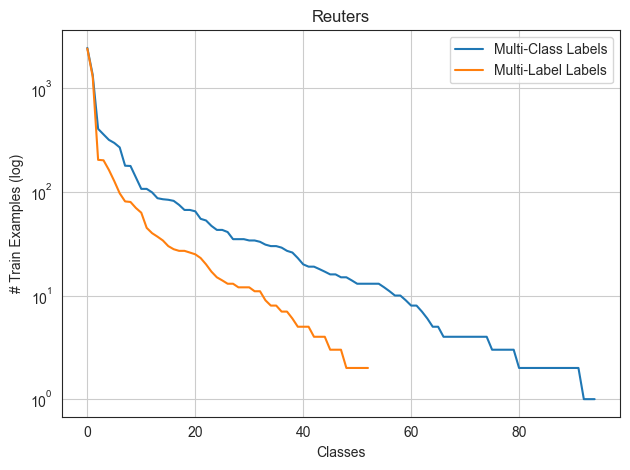

In [115]:
plt.figure(tight_layout=True)
plt.plot(classes_mlc, counts_mlc.sort(descending=True).values, label="Multi-Class Labels")
plt.plot(classes_cls, counts_cls.sort(descending=True).values, label="Multi-Label Labels")

plt.title("Reuters")
plt.xlabel("Classes")
plt.ylabel("# Train Examples (log)")
plt.yscale("log")
plt.grid()

plt.legend()
plt.savefig(os.path.join(output_dir, "Reuters.pdf"))

In [ ]:
# tokenize dataset
reuters_mlc[Split.TRAIN] = reuters_mlc[Split.TRAIN].map(tokenizer, input_columns="text", batched=True, num_proc=8)

In [63]:
# compute sequence lengths
lengths = reuters_mlc[Split.TRAIN].map(lambda ids: {"length": len(ids)}, input_columns="input_ids")["length"]

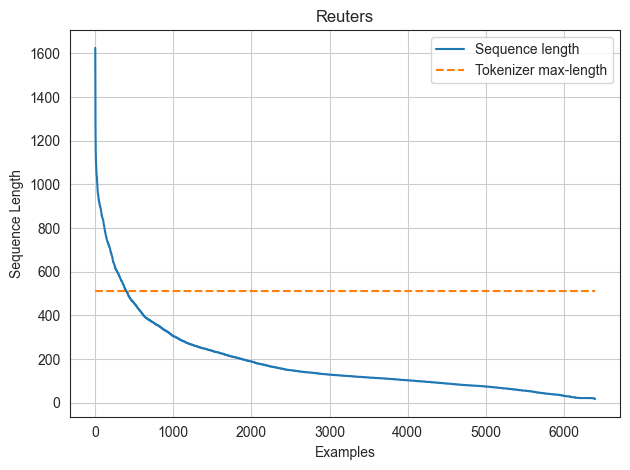

In [64]:
plt.figure(tight_layout=True)
plt.plot(lengths.sort(descending=True).values, label="Sequence length")
plt.plot(torch.ones_like(lengths) * 512, linestyle="--", label="Tokenizer max-length")

plt.title("Reuters")
plt.xlabel("Examples")
plt.ylabel("Sequence Length")
plt.grid()

plt.legend()
plt.savefig(os.path.join(output_dir, "Reuters-lengths.pdf"))

## AmazonCat-13K

In [118]:
amazoncat = load_from_disk(os.path.join(data_dir, "AmazonCat-13K"))
amazoncat.set_format("torch")

print("AmazonCat-13K")
print("Train", len(amazoncat[Split.TRAIN]))
print("Validation", len(amazoncat[Split.VALIDATION]))
print("Test", len(amazoncat[Split.TEST]))

AmazonCat-13K
Train 1181223
Validation 5000
Test 306778


In [125]:
classes, counts = torch.cat(amazoncat[Split.TRAIN]["labels"]).unique(return_counts=True)

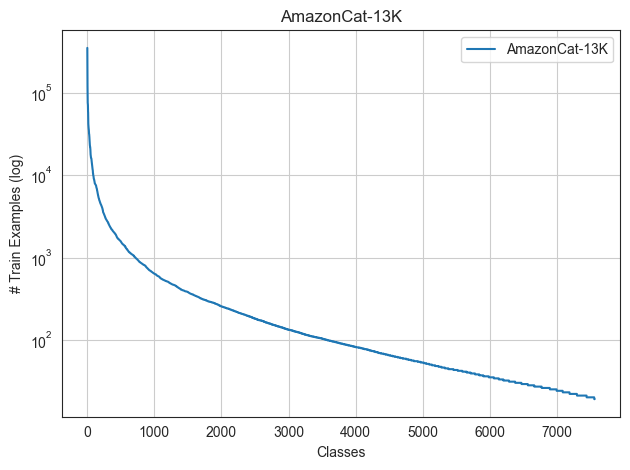

In [128]:
plt.figure(tight_layout=True)
plt.plot(classes, counts.sort(descending=True).values, label="AmazonCat-13K")

plt.title("AmazonCat-13K")
plt.xlabel("Classes")
plt.ylabel("# Train Examples (log)")
plt.yscale("log")
plt.grid()

plt.legend()
plt.savefig(os.path.join(output_dir, "AmazonCat-13K.pdf"))

In [129]:
# tokenize dataset
amazoncat[Split.TRAIN] = amazoncat[Split.TRAIN].map(tokenizer, input_columns="text", batched=True, num_proc=8)

In [130]:
# compute sequence lengths
lengths = amazoncat[Split.TRAIN].map(lambda ids: {"length": len(ids)}, input_columns="input_ids")["length"]

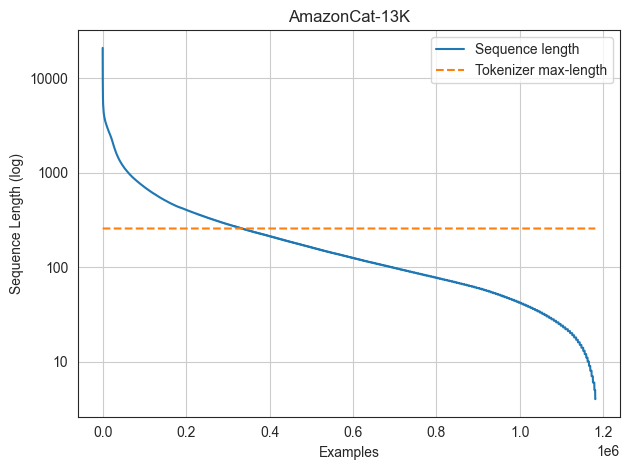

In [132]:
plt.figure(tight_layout=True)
plt.plot(lengths.sort(descending=True).values, label="Sequence length")
plt.plot(torch.ones_like(lengths) * 256, linestyle="--", label="Tokenizer max-length")

plt.yscale("log")
ax = plt.gca()
formatter = ticker.StrMethodFormatter('{x:.0f}')
ax.yaxis.set_major_formatter(formatter)

plt.title("AmazonCat-13K")
plt.xlabel("Examples")
plt.ylabel("Sequence Length (log)")
plt.grid()

plt.legend()
plt.savefig(os.path.join(output_dir, "AmazonCat-13K-lengths.pdf"))